# Homework 5
## Sungwon Lee
### 017473950

## Step 1.

In [1]:
# load Fashion MNIST
import torch
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import FashionMNIST

In [2]:
fashion_mnist = FashionMNIST(root='data', train=True, download=True, \
                             transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))
                             

In [3]:
img, label = fashion_mnist[0]
print('Label: ', label)
print(img[:, 10:15, 10:15])
torch.min(img), torch.max(img)

Label:  9
tensor([[[-1.0000, -1.0000, -1.0000,  0.5137,  0.7882],
         [-0.9765, -1.0000, -0.9059,  0.7176,  0.7255],
         [-0.9529, -1.0000, -0.2235,  0.9137,  0.7412],
         [-1.0000, -1.0000, -0.5686,  0.8510,  0.7882],
         [-1.0000, -1.0000,  0.8588,  0.7725,  0.7020]]])


(tensor(-1.), tensor(1.))

Label:  9


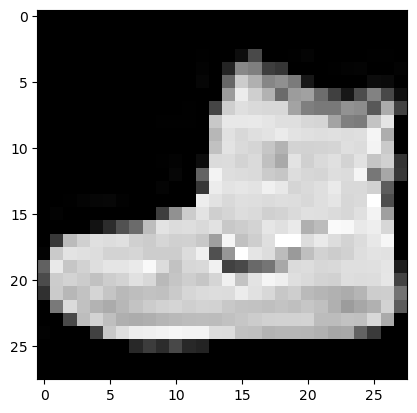

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

def denorm(x):
    out = (x+1)/2
    return out.clamp(0, 1)

img_norm = denorm(img)

plt.imshow(img_norm[0], cmap='gray')
print('Label: ', label)

first batch
torch.Size([100, 1, 28, 28])
tensor([0, 7, 4, 9, 2, 8, 7, 3, 9, 5, 2, 4, 3, 3, 7, 1, 3, 7, 7, 5, 3, 3, 3, 8,
        4, 9, 3, 5, 7, 2, 7, 8, 4, 4, 5, 1, 9, 3, 5, 2, 1, 8, 9, 3, 5, 6, 7, 3,
        4, 7, 6, 8, 9, 8, 4, 4, 8, 4, 6, 7, 3, 5, 8, 6, 2, 2, 6, 8, 2, 8, 8, 2,
        9, 7, 3, 3, 4, 0, 4, 8, 7, 4, 5, 0, 0, 3, 0, 1, 8, 3, 7, 9, 8, 9, 6, 1,
        5, 3, 9, 7])


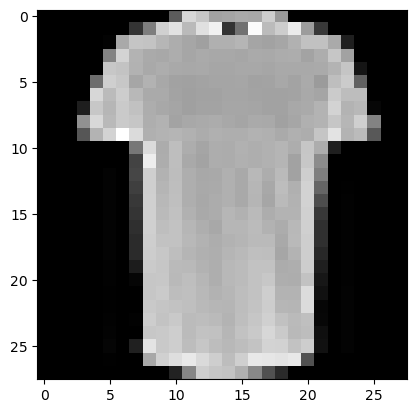

In [5]:
# create dataloader

from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(fashion_mnist, batch_size, shuffle=True)

for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

In [6]:
# use gpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

Discriminator Network

In [7]:
image_size = 784
hidden_size = 256

In [8]:
import torch.nn as nn

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

D.to(device);

Generator Network

In [9]:
latent_size = 64

In [10]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

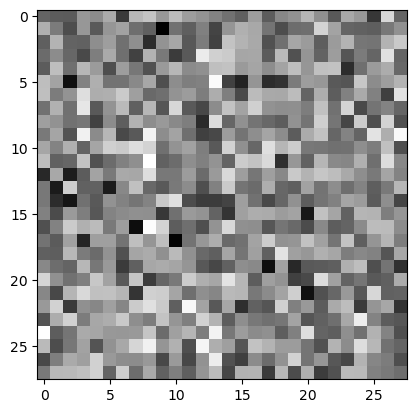

In [11]:
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28, 28)).detach())
plt.imshow(gen_imgs[0], cmap='gray')

## Step 2. Training

Generator Training

In [12]:
G.to(device);

In [13]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [14]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    # Create labels which are be used for later input for the BCE Loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # Discriminator(real) image loss
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Generator(fake) image loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # combine loss
    d_loss = d_loss_real + d_loss_fake

    reset_grad()

    # compute gradients
    d_loss.backward()

    # Adjust parameters using backprop
    d_optimizer.step()

    return d_loss, real_score, fake_score

Generator Training

In [15]:
def train_generator():
    # generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

Training the model

In [16]:
import os

sample_dir = "samples"
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

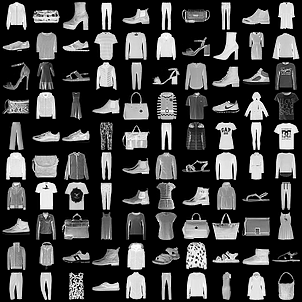

In [17]:
# saving real images
from IPython.display import Image
from torchvision.utils import save_image

for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, "real_images.png"), nrow=10)
    break

Image(os.path.join(sample_dir, "real_images.png"))

In [18]:
# save generated images batch for every epoch
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print("Saving", fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

Saving fake_images-0000.png


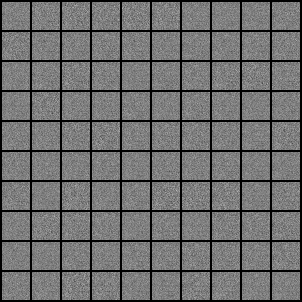

In [20]:
# before training

save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

TRAINING EACH EPOCH

In [21]:
%%time

num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # load batch, transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # train D and G
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_image = train_generator()

        # inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print(f"Epoch [{epoch}/{num_epochs}], Step [{i+1}/{total_step}], d_loss: {d_loss.item():.4f},\
                    g_loss: {g_loss.item():.4f}, D(x): {real_score.mean().item():.2f}, \
                    D(G(z)): {fake_score.mean().item():.2f}")


    save_fake_images(epoch + 1)


Epoch [0/300], Step [200/600], d_loss: 0.1225,                    g_loss: 3.9006, D(x): 0.97,                     D(G(z)): 0.08
Epoch [0/300], Step [400/600], d_loss: 0.2487,                    g_loss: 5.2134, D(x): 0.94,                     D(G(z)): 0.07
Epoch [0/300], Step [600/600], d_loss: 0.0370,                    g_loss: 4.7366, D(x): 0.99,                     D(G(z)): 0.02
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.0540,                    g_loss: 4.5081, D(x): 0.98,                     D(G(z)): 0.03
Epoch [1/300], Step [400/600], d_loss: 0.0655,                    g_loss: 3.6211, D(x): 0.99,                     D(G(z)): 0.05
Epoch [1/300], Step [600/600], d_loss: 0.0248,                    g_loss: 5.2630, D(x): 0.99,                     D(G(z)): 0.02
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.0207,                    g_loss: 5.5578, D(x): 1.00,                     D(G(z)): 0.02
Epoch [2/300], Step [400/600], d_loss: 0.0235,  

## Step 3. Display Image and describe difficulites

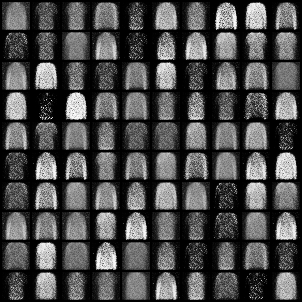

In [23]:
Image('./samples/fake_images-0010.png')

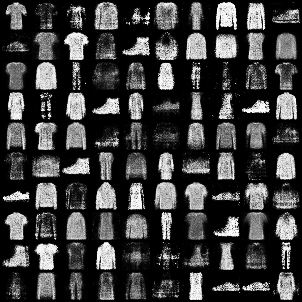

In [24]:
Image('./samples/fake_images-0100.png')

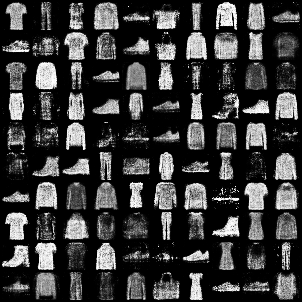

In [25]:
Image('./samples/fake_images-0200.png')

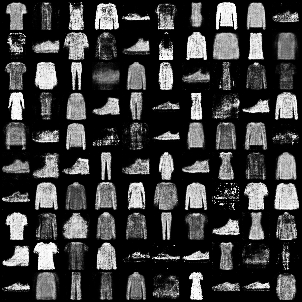

In [26]:
Image('./samples/fake_images-0300.png')

As we monitor the saved fake images at each batch point, it is evident that the quality of the images improves as the epochs progress. However, we also notice that, at certain epochs, the differences in image quality become less pronounced. For instance, when comparing the fake images generated at the 200th epoch and the 300th epoch, the enhancements appear subtle, making it challenging to discern significant improvements between these two points in the training process.



## Step 4. Save weight

In [28]:
import torch

def save_weight(model, model_name):
    filename = f"{model_name}_weight.pth"
    torch.save(model.state_dict(), filename)
    print(f"Saved {model_name} weight")

save_weight(G, "Generator")
save_weight(D, "Discriminator")

Saved Generator weight
Saved Discriminator weight
